<a href="https://colab.research.google.com/github/PCiunkiewicz/I4H_Workshop/blob/master/I4H_Data_Science_Workshop_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I4H Data Science Workshop Materials

#### Instructor -- Philip Ciunkiewicz (philip.ciunkiewicz@ucalgary.ca)
#### Organizer  -- Thomas Lijnse (technology@healthhackcompetition.com)
#### Organizer  -- Faizan Malik (director@healthhackcompetition.com)
#### Organizer  -- Jeremy Braun (translation@healthhackcompetition.com)
#### Organizer  -- Douglas Andrew Kondro (dakondro@ucalgary.ca)

## 0 Introduction / Preamble

Hello and welcome to the October 2019 I4H Data Science workshop! This notebook contains the supporting materials that we will be playing around with during this workshop and is accompanied by a set of PowerPoint slides which are available to view here (note that Google Slides may break some of the .pptx formatting so it's recommended to download the presentation and open in PowerPoint).

### 0.0 Installation (only need to run once)

This cell contains code for grabbing all of the necessary materials from GitHub as well as updating one of the packages which Google hasn't conveniently loaded in for us already. Commands which are prefixed with `!` go directly to the terminal instead of being executed by Python in the notebook.

In [0]:
!git clone https://github.com/PCiunkiewicz/I4H_Workshop.git
!pip install -U pandas-profiling -q

import os
os._exit(00)

fatal: destination path 'I4H_Workshop' already exists and is not an empty directory.


### 0.1 Imports

This cell contains some of the common library imports that we will need in this notebook. Python has thousands of external libraries for you to use, with constant updates and new libraries developed every year. Even if a task can be completed using the standard Python library, chances are there's easier and faster methods already published in external libraries.

In [0]:
try:
    import I4H_custom_functions as I4H
except ImportError:
    import I4H_Workshop.I4H_custom_functions as I4H

import pandas as pd
import pandas_profiling
import numpy as np

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### 0.2 Settings

This cell contains a few quality of life settings that make working easier for you. The `%matplotlib inline` command makes all of the plots that we make show up inline with our code, and the interactivity setting makes all outputs show up regardless of whether they're evaluated as the final line of the cell.

In [0]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 0.3 Help Function

Curious about what something is or how it works? Google colab allows you to hover over most code to view more detailed information, and there is also the very useful but underappreciated `help()` function built into Python.

In [39]:
help(I4H.load_data)

Help on function load_data in module I4H_Workshop.I4H_custom_functions:

load_data(dataset, simplify=True, missing=0)
    Load either the sample classification
    or regression dataset provided in the
    SKLearn library.
    
    Parameters:
    -----------
    dataset : str
        One of "classification" or "regression".
    simplify : bool
        If true removes some features for simplicity.
    missing : float
        Fraction of values to remove at random [0, 1).
        
    Returns:
    --------
    features : pd.DataFrame
        DataFrame containing the data features 
        (independent variables).
    target : pd.DataFrame
        DataFrame containing the data target
        (dependent variable).
    description : str
        Descriptive text providing a summary of the data.



## 1 Handling Data
### 1.1 Loading the Dataset into Python

With our libraries imported, let's start by loading and exploring a classification dataset. There are some premade functions in the module `I4H_custom_functions` which are specifically made for better readability in this workshop. Making your own module is as simple as creating a new `.py` file and then importing it as if it were an external library.

Our first custom function pulls a dataset from an online repository, and loads it into Python as a table (DataFrame) of features, `X`, a DataFrame of targets, `y`, and the description telling us about the dataset.

DataFrames are data structures from the Pandas library, modelled after the same structures in R. Storing our data in DataFrames provides us with an incredibly robust framework for data handling and transformation, as well as hundreds of tools for operating on our data. We are using a custom function to load data for readability, but if you have your own data as a `.csv` file then loading it is as simple as calling `pd.read_csv('filename.csv')`!

In [0]:
X, y, description = I4H.load_data('classification')

print(description)

### 1.2 Exploring the Dataset

With the dataset loaded, we can start exploring the features and targets. The library `Pandas-Profiling` offers us with an extensive report feature that provides a lot of basic insight and summary statistics. Let's join our features and target values into one table using `pd.concat()` and generate a report.

In [0]:
full_raw_data = pd.concat([X, y], axis=1)
report = full_raw_data.profile_report(style={'full_width':True})

report

### 1.3 Removing Highly Correlated Features

From our profiling report, we have found that there are quite a few features which are highly correlated. Features which are highly correlated generally do not provide the model with much (or any) benefit in terms of predictive ability, and in some cases may even be detrimental. Let's remove all of the variables which have been rejected due to high correlation (> .90 threshold by default).

In [6]:
correlated = report.get_rejected_variables()

print(f'Shape before: {X.shape}')
X.drop(correlated, axis=1, inplace=True)
print(f'Shape after:  {X.shape}')

Shape before: (569, 20)
Shape after:  (569, 12)


### 1.4 Splitting the Dataset

In order to validate our predictive models, we will need some data to test them with. This data is usually not acquired separately to the data which we feed our model, instead we split our dataset into a training set and a testing set. As with the profiling report, there is a convenient function already out there for this task: `train_test_split` from the library `SKLearn`.

In order to have reproducible results, we pass a "random seed" to the functions. This ensures that the random sampling is always the same between evaluations and we can make direct comparisons between models.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
print(f'Training set: {X_train.shape}; Testing set: {X_test.shape}')

Training set: (426, 12); Testing set: (143, 12)


### 1.5 Scaling the Dataset

From the profiling report, we can see that we have a lot of features which do not have the same range of values. To remedy this and ensure that our model will not heavily bias some features over the rest based on magnitude, we need to scale the inputs. To do this we will use the `StandardScaler` from SKLearn which rescales our data to zero-mean and unit-variance.

The best practice for scaling features is to use the training set to define the transformation parameters (population mean, population standard deviation, etc.) and to apply the identical transformation to both training and testing data. In machine learning, it is not always necessary to scale the target outputs, however models such as neural networks in deep learning will benefit from target scaling.

In [8]:
scaler = StandardScaler()
X_train_rs = scaler.fit_transform(X_train)
X_test_rs = scaler.transform(X_test)

print(f'Rescaled X_train -- mean: {X_train_rs.mean()}; std: {X_train_rs.std()}')
print(f'Rescaled X_test  -- mean: {X_test_rs.mean()}; std: {X_test_rs.std()}')

Rescaled X_train -- mean: 2.1683229025542963e-16; std: 0.9999999999999998
Rescaled X_test  -- mean: -0.02906795757490124; std: 0.9761372240516445


## 2 Machine Learning Part 1 (Classification)
### 2.1 Creating a Model

With our data loaded and some basic pre-processing out of the way, let's try creating a model and making some predictions. For this example we will create a `RandomForestClassifier` estimator from `SKLearn` which is made up of 100 decision trees. We will fit this model on our training data and see how accurate it is in this basic configuration.

In [9]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=10)
model = model.fit(X_train_rs, y_train['target'])
print(f'Model accuracy: {model.score(X_test_rs, y_test)}')

Model accuracy: 0.9440559440559441


### 2.2 Exploring the Model Predictions and Features

Model accuracy is important, but it is only a small part of the full story. In order to get a better understanding of how well our model will perform we need to further explore the predictions that it is returning and the features it is using to make decisions.

#### 2.2.1 Confusion Matrix

The confusion matrix compares the correct and incorrect classifications across all classes. The diagonal elements of this matrix always contain the correct classifications, and the off-diagonal elements represent misclassifications. This method of model evaluation is useful for identifying commonly misclassified samples and diagnosing potential outliers or bad data, as well as diagnosing weak points of the model.

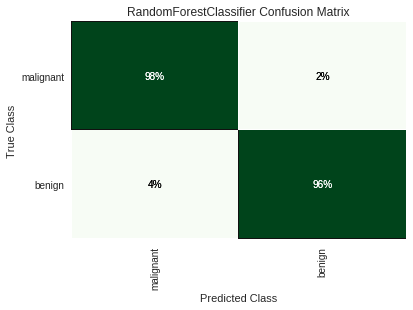

In [10]:
I4H.draw_confusion_matrix(model, X, y, classnames=['malignant', 'benign'])

#### 2.2.2 Feature Importances

Feature importance is a measure of how much a particular variable influences the decision making of the model. For models such as decision trees, this quantity is well defined and straight-foward to interpret, however not all models have an analogous quantity. The higher the relative importance a feature has, the more often it is used to make decisions during the classification process.

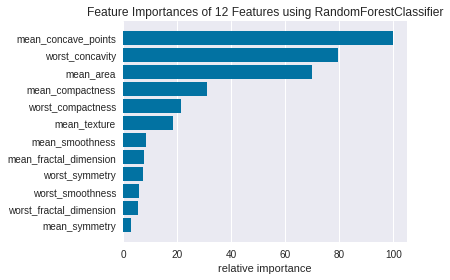

In [11]:
I4H.draw_feature_importances(model, X, y)

#### 2.2.3 Recursive Feature Elimination

Recursive feature elimination cross validation (RFECV) is a technique used to diagnose potentially "confusing" features which reduce the predictive ability of the model. This technique can also identify features which are highly correlated and thus provide little to no information value to the model.

RFECV works by training the model using only a select subset of the input features and returning a cross-validated score for that subset. Using fewer features is ideal when there is no trade-off in terms of model performance, as it will take less time to train and offer a "purer" and less complicated relationship.

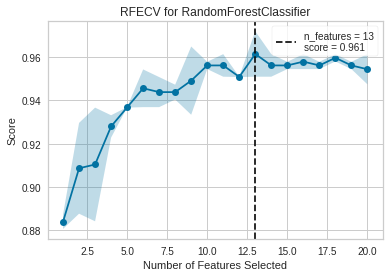

In [0]:
I4H.draw_RFECV(model, X, y)

### 2.2.4 Decision Boundaries

Decision boundaries show you what the model is thinking across the full range of features. Generating a plot of the decision boundaries is a powerful way of identifying model overfitting, which cannot be diagnosed using scalar accuracy metrics. 

Since plots are two or three dimensional, it only makes sense to visualize two or three features at a time for the decision boundaries. In this case we can select two of the higher importance features to visualize.

Note: Higher dimension visualizations can be generated using dimensionality reduction techniques such as linear discriminant analysis (LDA) or principal component analysis (PCA). These techniques are very powerful in general, and definitely worth some extra reading if you are interested.

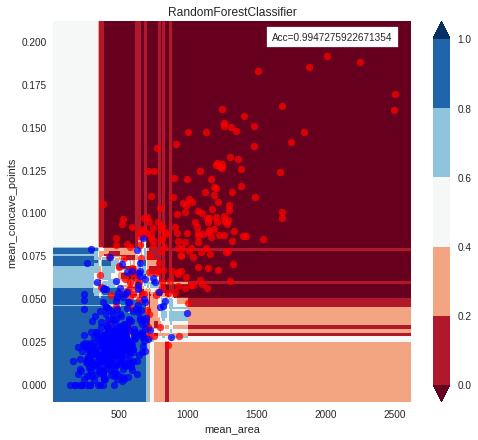

In [12]:
features = ['mean_area', 'mean_concave_points']
I4H.draw_decisions(model, X, y, features)

### 2.3 Alternative Models

Different models are designed for different applications, and model selection is not always a clear-cut process. [This cheatsheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) provides a starting off point for model selection based on general applications, however experimentation is always recommended.

Let's load a variety of models and explore their decision boundaries to get an intuition for how they work under the hood.

In [0]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

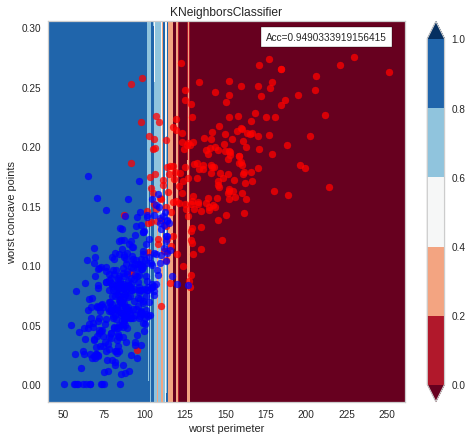

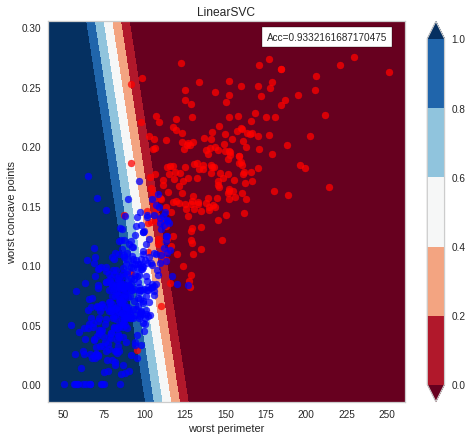

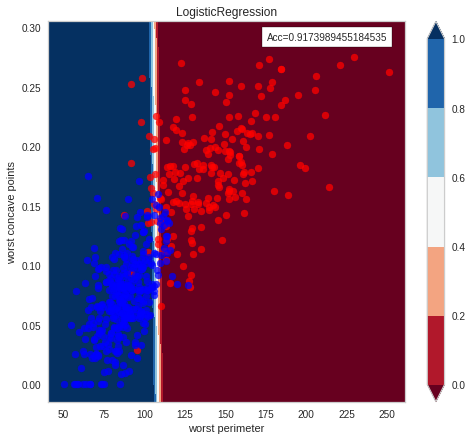

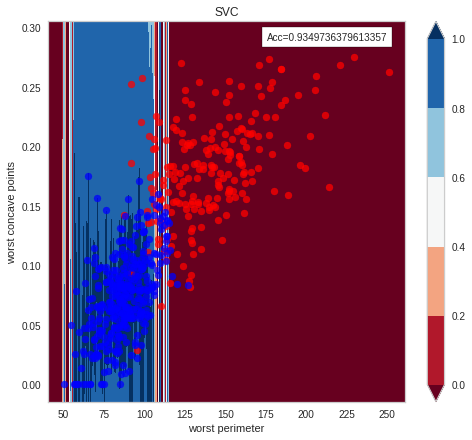

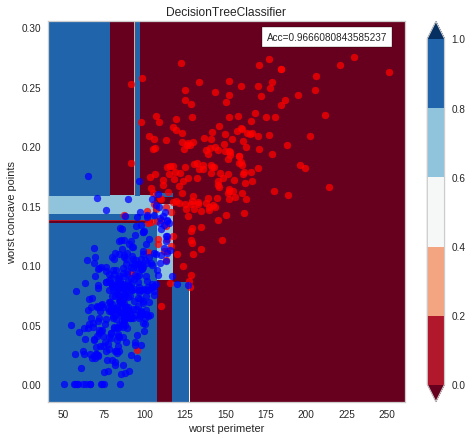

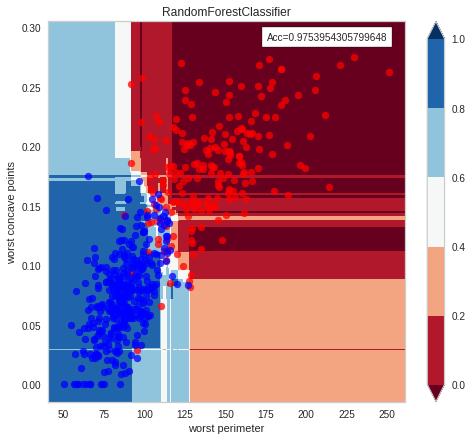

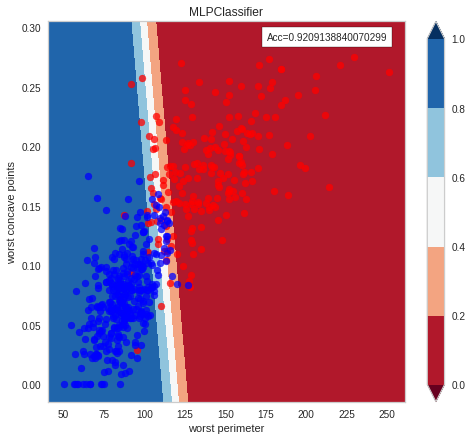

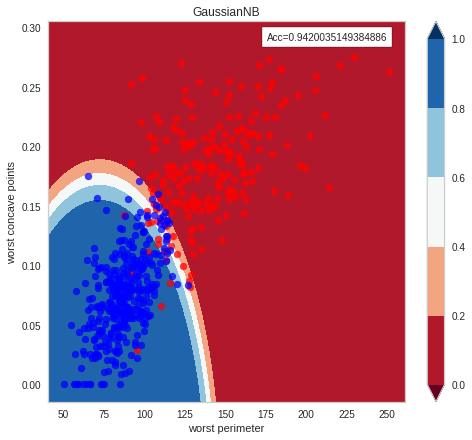

In [0]:
classifiers = [
    KNeighborsClassifier(3),
    LinearSVC(max_iter=10000, dual=False),
    LogisticRegression(solver='lbfgs'),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier((8, 8, 4), activation='tanh', batch_size=32),
    GaussianNB()
]

features = ['worst perimeter', 'worst concave points']

for model in classifiers:
    I4H.draw_decisions(model, X, y, features)    

## 3 Machine Learning Part 2 (Regression)
### 3.0 Catching up to Step 2.1

To explore a regression problem, we need data with continuous target values. We can use the same `I4H.load_data()` function as before to load new data, as well as similar preprocessing steps.

#### 3.0.1 Loading the Dataset into Python

This time we will add some missing values, with `missing=0.01` replacing 1% of the total dataset with null values (NaN).

In [13]:
X, y, description = I4H.load_data('regression', missing=0.01)

print(description)

#### 3.0.2 Exploring the Dataset



In [0]:
full_raw_data = pd.concat([X, y], axis=1)
report = full_raw_data.profile_report(style={'full_width':True})

report

#### 3.0.3 Removing Incomplete Samples

We are going to use the simplest method of dealing with missing data: removing all rows with missing values. This is done really easily in Pandas using the `DataFrame.dropna()` function.

In [14]:
print(f'Shape Before: {X.shape}')
X.dropna(inplace=True)
print(f'Shape After:  {X.shape}')

Before: (20640, 8)
 After: (19040, 8)


#### 3.0.4 Addressing Skewness

From the profiling report, we can see that some of the features are very strongly skewed. This can be remedied by removing values with poor zscores (# std from mean) from the data. Outlier removal can also be accomplished with explicit thresholds, or with filtering by quantiles.

In [15]:
outliers = np.abs(stats.zscore(X)) > 3
print(f'Number of outliers: {outliers.sum()}')

X = X[~outliers.any(axis=1)]

Number of outliers: 890


#### 3.0.5 Re-aligning the Target Values

We need to also make sure that the values in our target line up with the rows in our features, which can be done with the DataFrame index.

In [16]:
print(f'Target: {y.shape}, Features: {X.shape}')
y = y.loc[X.index]
print(f'Target after index matching: {y.shape}')

Target: (20640, 1), Features: (18264, 8)
Target after index matching: (18264, 1)


#### 3.0.6 Splitting the Dataset

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
print(f'Training set: {X_train.shape}; Testing set: {X_test.shape}')

Training set: (13698, 8); Testing set: (4566, 8)


#### 3.0.7 Scaling the Dataset

In [18]:
scaler = StandardScaler()
X_train_rs = scaler.fit_transform(X_train)
X_test_rs = scaler.transform(X_test)

print(f'Rescaled X_train -- mean: {X_train_rs.mean()}; std: {X_train_rs.std()}')
print(f'Rescaled X_test  -- mean: {X_test_rs.mean()}; std: {X_test_rs.std()}')

Rescaled X_train -- mean: 6.099499484683222e-16; std: 1.0
Rescaled X_test  -- mean: 0.003151233420930072; std: 0.9952866179023071


### 3.1 Creating a Model

Now that all of the data preprocessing is done, we can create and train a regression model using our new dataset. For this example we'll use `LinearRegression`, again from SKLearn.

In [19]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train_rs, y_train['target'])
print(f'Model r2 score: {model.score(X_test_rs, y_test)}')

Model r2 score: 0.6356315060906605


### 3.2 Exploring Model Predictions

Just as with the classifiers, we can explore the predictions that our model made using clever visualization techniques to gain insight beyond simple scores.

#### 3.2.1 Prediction Error

Prediction error plots the true known value, $y$, against its corresponding predicted value, $\hat{y}$. The identity line going through $\hat{y}=y$ corresponds to exact predictions, and the further away a point is from that line the less accurate the prediction was. This plot is useful for diagnosing which regions of your target range are the most challenging for the model to predict, and in the case of this dataset we can see some issues at $y=5$ due to the dataset truncating house value at $500,000 in the study.

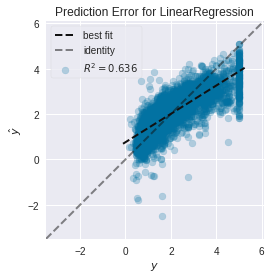

In [22]:
I4H.draw_prediction_error(model, X, y)

#### 3.2.2 Residuals Plot

Residuals represent the difference between the actual and predicted values, $\hat{y}-y$. The residuals plot offers much of the same information as the prediction error plot, however it has the added benefit of maintaining the same range along the residuals axis which allows for convenient viewing of the residual distribution plot.

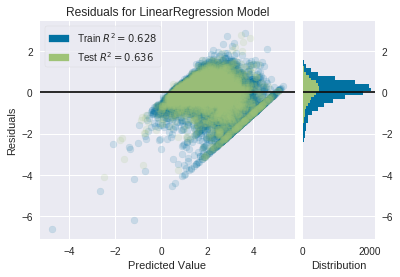

In [23]:
I4H.draw_residuals(model, X, y)

### 3.3 Alternative Models

As with the previous example, let's load some more regression models from SKLearn and explore the residuals for each of them to get a sense of their strengths and weaknesses.

In [0]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import NuSVR

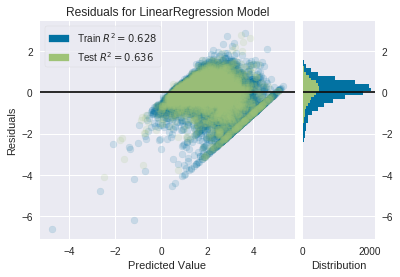

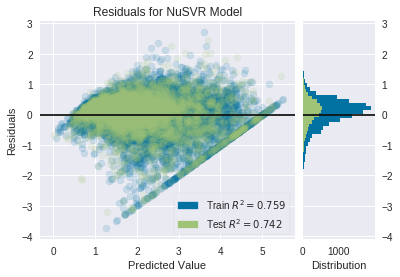

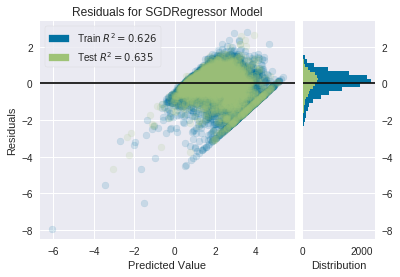

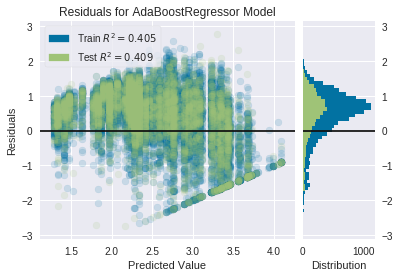

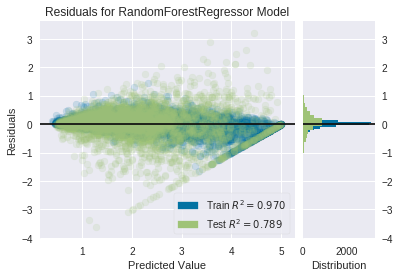

In [26]:
regressors = [
    LinearRegression(), 
    NuSVR(0.2, gamma='scale'),
    SGDRegressor(),
    AdaBoostRegressor(),
    RandomForestRegressor(100)
]

for model in regressors:
    I4H.draw_residuals(model, X, y)

## 4 Cross Validation

Cross validation is a very important technique for diagnosing model overfitting as well as offering a more robust and representative performance evaluation. The basic principle of cross validation is simple, split (fold) the dataset and train the model multiple times to see how it performs across the full range of values instead of a select testing set. Each run is fully independent, and the model is returned to a clean slate for all folds. 

Cross validation is a powerful but sometimes confusing idea, so please refer to the presentation slides for a nice visualization of the technique.

### 4.1 Employing Cross Validation in Model Selection

Being such a powerful technique, there are of course implementations already offered in packages such as SKLearn which take care of all of the steps: managing the different indices for all of the folds; training the model; scoring the model; tracking all of the scoring results.

In [35]:
from sklearn.model_selection import cross_validate

for model in regressors:
    cv_results = cross_validate(model, X_train_rs, y_train['target'], cv=5)
    df = pd.DataFrame(cv_results).T
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)

    print('\n', model.__class__.__name__)
    df


 LinearRegression


,0,1,2,3,4,mean,std
fit_time,0.011308,0.005798,0.004477,0.007202,0.004318,0.006621,0.002565
score_time,0.001924,0.001151,0.001322,0.001137,0.001099,0.001327,0.000308
test_score,0.641559,0.624201,0.623276,0.614954,0.628185,0.626435,0.008702



 NuSVR


,0,1,2,3,4,mean,std
fit_time,3.934331,4.110522,4.038724,4.000442,3.867901,3.990384,0.083684
score_time,0.222611,0.218030,0.227941,0.216174,0.220243,0.221000,0.004086
test_score,0.753755,0.737769,0.746267,0.732245,0.717650,0.737537,0.012352



 SGDRegressor


,0,1,2,3,4,mean,std
fit_time,0.021591,0.031992,0.042204,0.037416,0.025841,0.031809,0.007477
score_time,0.003958,0.001609,0.002297,0.002718,0.001894,0.002495,0.000821
test_score,0.643872,0.623163,0.621063,0.615614,0.625280,0.625799,0.009592



 AdaBoostRegressor


,0,1,2,3,4,mean,std
fit_time,0.754205,0.467225,0.633965,0.824792,0.845065,0.705050,0.139980
score_time,0.009802,0.005957,0.009134,0.011672,0.012255,0.009764,0.002224
test_score,0.446756,0.488035,0.449414,0.416566,0.412452,0.442645,0.027257



 RandomForestRegressor


,0,1,2,3,4,mean,std
fit_time,7.507694,7.589099,7.511150,7.355740,7.399702,7.472677,0.083976
score_time,0.122313,0.118726,0.110800,0.116658,0.089204,0.111540,0.011776
test_score,0.787474,0.781517,0.783425,0.779403,0.766857,0.779735,0.006966


## 5 Conclusion

In attending this workshop you will hopefully have enough background to start applying some of these techniques to your own research and projects. Data science is a huge field and it is growing at a rapid pace, so there are always thousands of new ideas to learn and techniques to master. I will leave you with a few excellent resources for further reading into theory, technical applications, and support for when code inevitably doesn't work how we expect it to.

__Articles__
 - https://towardsdatascience.com/
 - https://www.datasciencecentral.com/
 - https://www.kaggle.com/
 - https://simplystatistics.org/
 - https://ai.googleblog.com
 
__Technical Resources__
 - https://pandas.pydata.org/pandas-docs/version/0.25/#
 - https://scikit-learn.org/stable/
 - https://www.tensorflow.org
 - https://docs.scipy.org/doc/

__Support__
 - https://stackoverflow.com/questions
 - Google
 - Someone you know who's smart